In [ ]:
# 1) сетка resnet 18 (предобученная на imagenet) -> поменять у нее голову
# 2) размеченный датасет
# 3) dataset loader (трейн/валидация)
# 4) процедура обучения
# 5) лосс (метрику?)
# 6) визуализация результата

In [ ]:
!unzip Archive.zip

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
from torch.utils.data import Dataset, DataLoader
import json
import os
from skimage import io, transform
from PIL import Image
import numpy as np
from pprint import pprint

class MaskDataset(Dataset):
    def __init__(self, json_path, root_dir, transform=None):
        with open(json_path) as json_fp:
            self.annotations = json.load(json_fp)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        
        img_path = os.path.join(self.root_dir, annotation['file_upload'])

        image = Image.open(img_path)

        image_width = image.size[1]
        image_height = image.size[0] 

        annotation_result = annotation['annotations'][0]['result']

        if annotation_result:
            annotation_value = annotation_result[0]['value']
            x = (annotation_value['x'] + annotation_value['width'] / 2) / 100
            y = (annotation_value['y'] + annotation_value['height'] / 2) / 100
            w = annotation_value['width'] / 100
            h = annotation_value['height'] / 100
            has_object = 1
        else:
            x, y, w, h = 0, 0, 0, 0 
            has_object = 0

        if self.transform:
            image = self.transform(image)
            image = image[:3]

        sample = {'image': image, 'x': x, 'y': y, 'w': w, 'h': h, 'has_object': has_object}

        return sample

In [ ]:
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ])

dataset = MaskDataset('project-3-at-2021-04-12-18-33-ba259df6.json', 'masks_dataset', transform=data_transform)
len(dataset)

66

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, 
                                                    [train_size, test_size], 
                                                    generator=torch.Generator().manual_seed(42))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
len(train_loader), len(test_loader)

(13, 4)

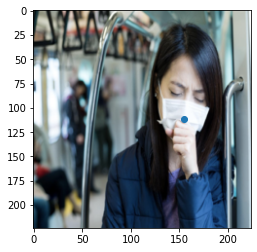

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot(sample, xy_pred=None):
    img_tensor = sample['image']

    image = np.moveaxis(img_tensor.numpy(), 0, 2)
    image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])

    plt.imshow(image)

    image_height, image_width = image.shape[:2]

    x = int(sample['x'] * image.shape[1])
    y = int(sample['y'] * image.shape[0])
    plt.scatter(x, y)

    # x_left_top = int((sample['x'] - sample['w'] / 2) * image.shape[1])
    # y_left_top = int((sample['y'] - sample['h'] / 2) * image.shape[0])
    # plt.scatter(x_left_top, y_left_top)

    # x_right_bottom = int((sample['x'] + sample['w'] / 2) * image.shape[1])
    # y_right_bottom = int((sample['y'] + sample['h'] / 2) * image.shape[0])
    # plt.scatter(x_right_bottom, y_right_bottom)

    if xy_pred is not None:
        plt.scatter(xy_pred[0] * image.shape[1], xy_pred[1] * image.shape[0])

    plt.show()

plot(dataset[7])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision.models import resnet18
from torch.nn import Sequential


net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
loss_function = torch.nn.L1Loss(reduction='none')

optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)

In [ ]:
for epoch in range(50):

    net.train()
    epoch_loss = 0.

    for batch in train_loader:
        images, x, y, w, h, has_object = (
            batch['image'],
            batch['x'],
            batch['y'],
            batch['w'],
            batch['h'],
            batch['has_object'])

        images = images.to(device)
        x = x.to(device)
        y = y.to(device)
        w = w.to(device)
        h = h.to(device)
        has_object = has_object.to(device)

        optimizer.zero_grad()
        predictions = net(images)

        num_objects = torch.sum(has_object)

        loss = torch.sum((
            loss_function(predictions[:,0], x) * has_object +
            loss_function(predictions[:,1], y) * has_object +
            loss_function(predictions[:,2], w) * has_object +
            loss_function(predictions[:,3], h) * has_object)) / num_objects

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Train: {epoch_loss / len(train_loader)}')

    net.eval()
    epoch_loss = 0.

    for batch in test_loader:
        with torch.no_grad():
            images, x, y, w, h, has_object = (
                batch['image'],
                batch['x'],
                batch['y'],
                batch['w'],
                batch['h'],
                batch['has_object'])

            images = images.to(device)
            x = x.to(device)
            y = y.to(device)
            w = w.to(device)
            h = h.to(device)
            has_object = has_object.to(device)

            predictions = net(images)

            num_objects = torch.sum(has_object)

            loss = torch.sum(
                loss_function(predictions[:,0], x) * has_object +
                loss_function(predictions[:,1], y) * has_object +
                loss_function(predictions[:,2], w) * has_object +
                loss_function(predictions[:,3], h) * has_object) / num_objects


            epoch_loss += loss.item()

    print(f'Test: {epoch_loss / len(test_loader)}')

Train: 0.07344055949495389
Test: 0.3302071690559387
Train: 0.054276783305865064
Test: 0.32542358338832855
Train: 0.044344522345524565
Test: 0.3285806104540825
Train: 0.05380621896340297
Test: 0.3237385153770447
Train: 0.052149245085624546
Test: 0.30729395151138306
Train: 0.05656955305200357
Test: 0.31538261100649834
Train: 0.04428289271891117
Test: 0.3315584808588028
Train: 0.045475041637053855
Test: 0.3245614692568779
Train: 0.04648981931117865
Test: 0.31688573583960533
Train: 0.051476808121571176
Test: 0.31984397396445274
Train: 0.04773251110544571
Test: 0.3234386742115021
Train: 0.04875055356667592
Test: 0.32314981520175934
Train: 0.04649847645599108
Test: 0.3301529064774513
Train: 0.03889516741037369
Test: 0.3296881690621376
Train: 0.03850642032921314
Test: 0.31682445108890533
Train: 0.03961049091930573
Test: 0.32180218771100044
Train: 0.0367556602622454
Test: 0.32438473030924797
Train: 0.03711865254892753
Test: 0.32657596468925476
Train: 0.03889434340481575
Test: 0.322949476540088

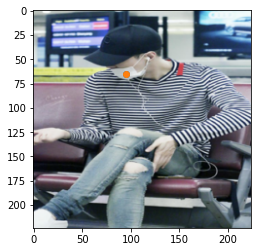

In [ ]:
sample = train_set[5] 

image = sample['image']
x = sample['x']
y = sample['y']

with torch.no_grad():
    pred = net(torch.unsqueeze(image, dim=0).to(device)).cpu().numpy()[0]

plot(sample, xy_pred=pred[:2])